# Transverse Ising Model

The hamiltonian for the 1D transverse Ising model is given by 
\begin{equation}
\mathcal{H} = -\Gamma\sum_{i=1}^{N}S_{i}^{z} - J\sum_{i=1}^{N}S_{i}^{x}S_{i+1}^{x} ,
\end{equation}

where $\Gamma$ is the tunneling energy, $S^{x}$ and $S^{z}$ are spin $1/2$ operators, and $J$ is the interaction parameter <a name="ref-1"/>[(Pfeuty, 1970)](#cite-Pfeuty). In units of $J = 1$, and $\hbar = 1$, the above hamiltonian can be simplified to

\begin{equation}
\mathcal{H} = -\frac{g}{2}\sum_{i=1}^{N}\sigma_{i}^{z} - \frac{1}{4}\sum_{i=1}^{N}\sigma_{i}^{x}\sigma_{i+1}^{x} ,
\end{equation}

where $\sigma^z$ and $\sigma^x$ are Pauli matrices. In this example, the variational quantum eigensolver (VQE) approach is used to calculate the ground state energy of the hamiltonian above for different values of $g$. The results are the compared to the exact solution <a name="ref-2"/>[(Pfeuty, 1970)](#cite-Pfeuty). Note that a similar problem is discussed in <a name="ref-3"/>[(Coles, 2018)](#cite-Coles2018QuantumAI).
Implementation using __[Pennylane](https://pennylane.ai/)__.

In [1]:
import pennylane as qml
from pennylane import numpy as np #Always import numpy from pennylane
import matplotlib.pyplot as plt

In [3]:
n = 4 #Number of qubits

#Construct a QNode
#Initialize device
qcdev = qml.device("default.qubit", wires=n)
@qml.qnode(qcdev)
def Circuit(theta,g,Wires):
    
    theta = theta.reshape((n,3))

    #Prepare initial state
    #Apply U3(theta[j]) to qubit j
    for j in range(n):
        qml.U3(theta[j,0], theta[j,1], theta[j,2], wires=j)
     
    indx = Wires[0]
    if g > 0.0:
        return qml.expval(qml.PauliZ(indx))
    
    else:
        if indx < n - 1:
            return qml.expval(qml.PauliX(indx) @ qml.PauliX(indx+1))
        else:
            return qml.expval(qml.PauliX(indx) @ qml.PauliX(0))

        
#Test the Circuit function
theta = np.random.rand(3*n)
wires = [3]
print(Circuit(theta,1.0,Wires=wires))

0.94908809667625


In [4]:
#Objective function to optimize
def Cost(theta,gg):

    exp = 0.0
    for i in range(n):
        wrs = [i]
        exp -= 0.25*Circuit(theta,0.0,Wires=wrs)
        if gg > 0.0:
            exp -= 0.5*gg*Circuit(theta,gg,Wires=wrs)
            
    return exp/n 

#Test the Cost function
theta = np.random.rand(3*n)
print(Cost(theta,1.0))

-0.470961042393949


In [5]:
#Exact solution
#Returns Eg/n for a given g
#See Pfeuty's paper
st = int(n/2)
def Exact_Ising(x):
    tot = 0.0
    for m in range(-st,st):
        tot -= np.sqrt(0.25 + (x**2) + x*np.cos(2*np.pi*m/n))
        
    return 0.5*tot/n

print(Exact_Ising(0.0))

-0.25


In [6]:
#Optimization
#Initialize optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.25)

nsteps = 200 # number of steps
Theta0 = 2*np.random.rand(3*n) #Initial guess for theta


#Calculating the ground state energy for g = 0.0
gg = 0.0
EXP = np.zeros(nsteps)
exact = Exact_Ising(gg)
EXACT = exact*np.ones(nsteps)

params = Theta0
for i in range(nsteps):
    ## update parameters
    params = opt.step(lambda params:Cost(params,gg), params) #Need to have a function of only one parameter in this step
    
    EXP[i] = Cost(params,gg)

print("\nFinal parameters:")
print(params)
sim = Cost(params,gg)
print("\ng = %0.3f, Eg_sim/n = %0.7f, Eg_exact/n = %0.7f\n"%(gg,sim,exact))


Final parameters:
[1.56697461e+00 2.81954855e-03 1.00222706e+00 1.57026996e+00
 1.63790607e-03 1.77626897e+00 1.56889846e+00 5.64338858e-03
 1.68670102e+00 1.56571541e+00 3.76422607e-03 8.64900426e-01]

g = 0.000, Eg_sim/n = -0.2499937, Eg_exact/n = -0.2500000



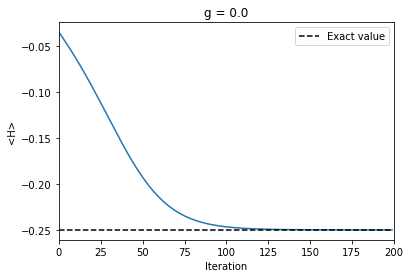

In [7]:
#<H> vs iteration
#Plot the results for g = 0.0
plt.plot(EXP)
plt.plot(EXACT,color='k',linestyle='--',label='Exact value')
plt.xlabel('Iteration')
plt.ylabel('<H>')
plt.xlim(0,nsteps)
plt.title('g = %0.1f'%(gg))
plt.legend(loc='best')
plt.show()

In [10]:
#Calculating the ground state energy for different values of g
Gs = [0.3*i for i in range(11)] #g values
SIM = [sim]
EXACT = [exact]
for gg in Gs:
    if gg > 0.0:
        params = Theta0
        for i in range(nsteps):
        
            ## update parameters
            params = opt.step(lambda params:Cost(params,gg), params) 
    
        SIM.append(Cost(params,gg))
        EXACT.append(Exact_Ising(gg))

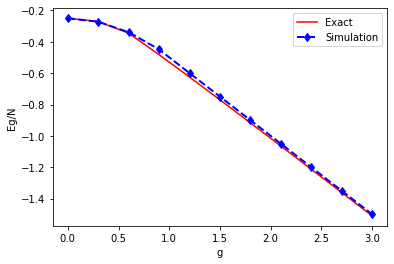

In [12]:
#Comparing simulation results to exact values
plt.plot(Gs,EXACT,color='r',label='Exact')
plt.plot(Gs,SIM,'d',linewidth=2,linestyle='--',color='b',label='Simulation')
plt.xlabel('g')
plt.ylabel('Eg/N')
plt.legend(loc='best')
plt.show()

<!--bibtex

@book{MikeIke,
    title = {Quantum Computation and Quantum Information},
    author = {Nielsen, Michael A. and Chuang, Issac L},
    year = {2010},
    publisher = {Cambridge University Press}
}

@book{Sachdev,
    title = {Quantum Phase Transitions},
    author = {Sachdev, Subir},
    year = {2011},
    publisher = {Cambridge University Press}
}


@article{Coles2018QuantumAI,
  title={Quantum Algorithm Implementations for Beginners},
  author={Coles, Patrick J. and S. Eidenbenz and S. Pakin and A. Adedoyin and J. Ambrosiano and P. Anisimov 
          and W. Casper and Gopinath Chennupati and Carleton Coffrin and H. Djidjev and David Gunter and S. Karra 
          and N. Lemons and Shizeng Lin and A. Lokhov and A. Malyzhenkov and David Mascarenas and S. Mniszewski 
          and B. Nadiga and D. O'Malley and D. Oyen and Lakshman Prasad and Randy Roberts and P. Romero 
          and N. Santhi and N. Sinitsyn and P. Swart and Marc Vuffray and J. Wendelberger and B. Yoon 
          and R. Zamora and W. Zhu},
  journal={ArXiv},
  year={2018},
  volume={abs/1804.03719}
}

@article{Pfeuty,
       author = {Pfeuty, Pierre},
        title = {The one-dimensional Ising model with a transverse field},
      journal = {Annals of Physics},
         year = 1970,
        month = mar,
       volume = {57},
       number = {1},
        pages = {79-90},
          doi = {10.1016/0003-4916(70)90270-8},
       adsurl = {https://ui.adsabs.harvard.edu/abs/1970AnPhy..57...79P},
      adsnote = {Provided by the SAO/NASA Astrophysics Data System}
}

-->

# References

<a name="cite-Pfeuty"/><sup>[^](#ref-1) [^](#ref-2) </sup>Pfeuty, Pierre. 1970. _The one-dimensional Ising model with a transverse field_.

<a name="cite-Coles2018QuantumAI"/><sup>[^](#ref-3) </sup>Coles, Patrick J. and S. Eidenbenz and S. Pakin and A. Adedoyin and J. Ambrosiano and P. Anisimov 
          and W. Casper and Gopinath Chennupati and Carleton Coffrin and H. Djidjev and David Gunter and S. Karra 
          and N. Lemons and Shizeng Lin and A. Lokhov and A. Malyzhenkov and David Mascarenas and S. Mniszewski 
          and B. Nadiga and D. O'Malley and D. Oyen and Lakshman Prasad and Randy Roberts and P. Romero 
          and N. Santhi and N. Sinitsyn and P. Swart and Marc Vuffray and J. Wendelberger and B. Yoon 
          and R. Zamora and W. Zhu. 2018. _Quantum Algorithm Implementations for Beginners_.

